# Localize anatomic structures

In [27]:
import pandas as pd
import torch
import torch.nn as nn
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
import numpy as np
from PIL import Image
import os
from torchvision.models.mobilenetv2 import MobileNet_V2_Weights
from collections import defaultdict
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm
import mlflow


## Inference

In [ ]:
import onnxruntime as ort
import cv2

In [1]:
onnx_model_path = "onnx_exports/anatomy_detector.onnx"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
TARGET_HEIGHT = 400
TARGET_WIDTH = 600

NameError: name 'torch' is not defined

In [ ]:
# Save model as .onnx
def save_model_onnx(model, filename=onnx_model_path, input_shape=(1, 1, TARGET_HEIGHT, TARGET_WIDTH)):
    model.eval()
    dummy_input = torch.randn(input_shape).to(device)  # [B, C, H, W]
    
    torch.onnx.export(model, dummy_input, filename,
                      input_names=['input'],
                      output_names=['class_probs', 'boxes'],
                      dynamic_axes={
                          'input': {0: 'batch_size'},
                          'class_probs': {0: 'batch_size'},
                          'boxes': {0: 'batch_size'}
                      },
                      opset_version=12)
    print(f"Model saved to {filename}")

In [ ]:
save_model_onnx(model, filename=onnx_model_path, input_shape=(1, 1, TARGET_HEIGHT, TARGET_WIDTH))

ONNX model loaded successfully!
Output shapes - Class probabilities: (1, 9), Boxes: (1, 9, 4)
Average inference time for image 0: 3.077085e-02 seconds
Average inference time for image 1: 3.644736e-02 seconds
Average inference time for image 2: 3.890932e-02 seconds
Average inference time for image 3: 3.331196e-02 seconds
Average inference time for image 4: 3.418941e-02 seconds
Average inference time for image 5: 3.155642e-02 seconds
Average inference time for image 6: 2.830455e-02 seconds
Average inference time for image 7: 2.860117e-02 seconds
Average inference time for image 8: 2.928905e-02 seconds
Average inference time for image 9: 3.048389e-02 seconds

Overall average inference time across 10 images: 0.032186 seconds


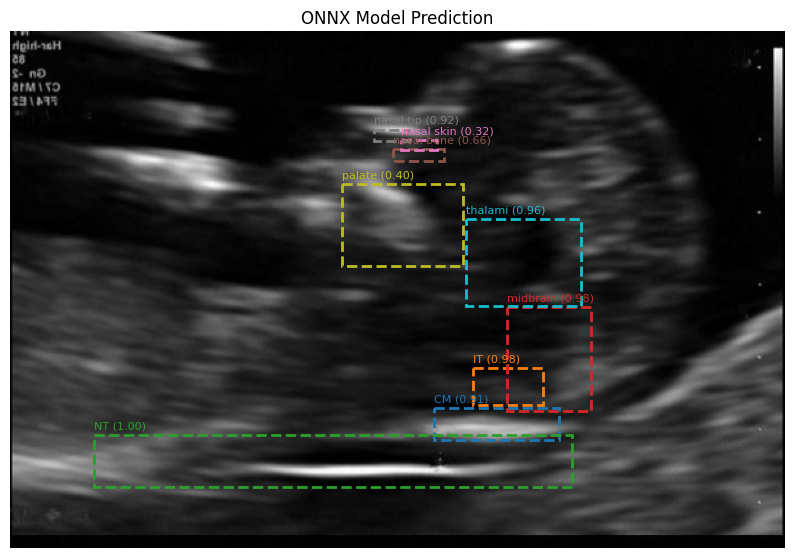

In [ ]:
# Load ONNX model

ort_session = ort.InferenceSession(onnx_model_path)

# Test inference with dummy input
dummy_input = np.random.randn(1, 1, TARGET_HEIGHT, TARGET_WIDTH).astype(np.float32)
ort_inputs = {'input': dummy_input}
ort_outputs = ort_session.run(None, ort_inputs)

print("ONNX model loaded successfully!")
print(f"Output shapes - Class probabilities: {ort_outputs[0].shape}, Boxes: {ort_outputs[1].shape}")

# Plot results from ONNX inference
def visualize_onnx_prediction(ort_session, img, threshold=0.3):
    img_input = img.unsqueeze(0).numpy()  # [1, 1, H, W]
    ort_inputs = {'input': img_input}
    
    pred_class, pred_boxes = ort_session.run(None, ort_inputs)
    pred_class = torch.tensor(pred_class.squeeze(0))  # [K]
    pred_boxes = torch.tensor(pred_boxes.squeeze(0))  # [K, 4]
    img_np = img.squeeze().numpy()  # [H, W]
    fig, ax = plt.subplots(1, figsize=(10, 10))
    ax.imshow(img_np, cmap='gray')
    colors = plt.get_cmap('tab10', len(structures))
    color_map = {structure: colors(i) for i, structure in enumerate(structures)}
    for class_idx in range(len(structures)):
        if pred_class[class_idx] > threshold:
            structure_name = id_to_structure[class_idx]
            cx, cy, w, h = pred_boxes[class_idx]
            draw_box(ax, cx, cy, w, h, TARGET_WIDTH, TARGET_HEIGHT,
                     label=f"{structure_name} ({pred_class[class_idx]:.2f})",
                     color=color_map[structure_name], style='dashed')
    plt.title('ONNX Model Prediction')
    plt.axis('off')

# Visualize ONNX prediction for the first validation image  
for i in range(1):  # Visualize 1 prediction
    img, _, _ = val_ds[i]
    visualize_onnx_prediction(ort_session, img, threshold=0.3)

# Calculate average inference time
def measure_inference_time(ort_session, dataset, num_images=10, runs_per_image=10):
    total_time = 0
    for i in range(num_images):
        img, _, _ = dataset[i]
        img_input = img.unsqueeze(0).numpy()  # [1, 1, H, W]
        ort_inputs = {'input': img_input}
        
        import time
        start_time = time.time()
        for _ in range(runs_per_image):
            ort_session.run(None, ort_inputs)
        end_time = time.time()
        
        avg_time = (end_time - start_time) / runs_per_image
        total_time += avg_time
        print(f"Average inference time for image {i}: {avg_time:.6e} seconds")
    
    overall_avg = total_time / num_images
    print(f"\nOverall average inference time across {num_images} images: {overall_avg:.6f} seconds")
    return overall_avg

# Measure inference time across multiple validation images
avg_time = measure_inference_time(ort_session, val_ds, num_images=10, runs_per_image=10)


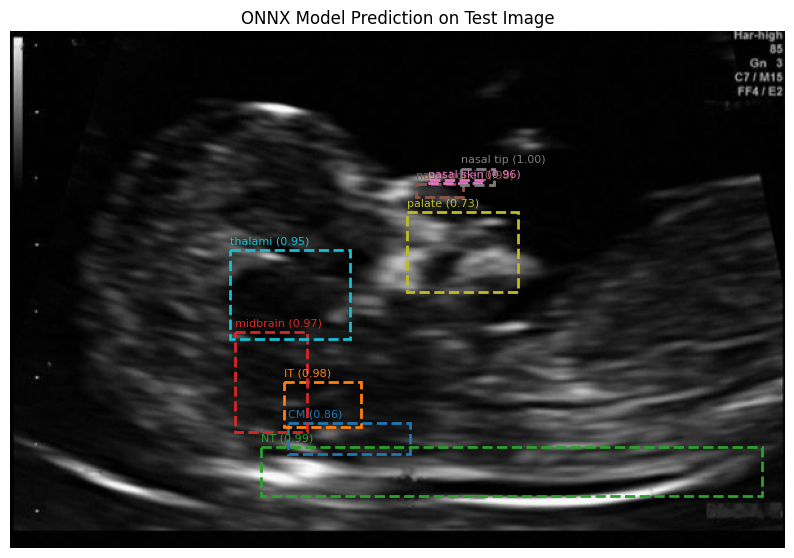

In [ ]:
# Load ONNX model
ort_session = ort.InferenceSession(onnx_model_path)

# test with image 1528.png 
test_img_path = "dataset/Dataset for Fetus Framework/Internal Test Set/Standard/1528.png"

# apply same transforms as training
test_img = cv2.imread(test_img_path, cv2.IMREAD_GRAYSCALE)  # Load as grayscale
test_img = cv2.resize(test_img, (TARGET_WIDTH, TARGET_HEIGHT))  # Resize to target dimensions
test_img = (test_img / 255.0 - 0.5) / 0.5
test_img = torch.tensor(test_img, dtype=torch.float32).unsqueeze(0).unsqueeze(0)  # [1, 1, H, W]

# Run inference
ort_inputs = {'input': test_img.numpy()}
ort_outputs = ort_session.run(None, ort_inputs)
pred_class = torch.tensor(ort_outputs[0].squeeze(0))  # [K]
pred_boxes = torch.tensor(ort_outputs[1].squeeze(0))  # [K, 4]
# Visualize the prediction
def visualize_onnx_test_prediction(pred_class, pred_boxes, img, threshold=0.3):
    img_np = img.squeeze().numpy()  # [H, W]
    _, ax = plt.subplots(1, figsize=(10, 10))
    ax.imshow(img_np, cmap='gray')
    colors = plt.get_cmap('tab10', len(structures))
    color_map = {structure: colors(i) for i, structure in enumerate(structures)}
    
    for class_idx in range(len(structures)):
        if pred_class[class_idx] > threshold:
            structure_name = id_to_structure[class_idx]
            cx, cy, w, h = pred_boxes[class_idx]
            draw_box(ax, cx, cy, w, h, TARGET_WIDTH, TARGET_HEIGHT,
                     label=f"{structure_name} ({pred_class[class_idx]:.2f})",
                     color=color_map[structure_name], style='dashed')
    
    plt.title('ONNX Model Prediction on Test Image')
    plt.axis('off')
    plt.show()

# Visualize the prediction on the test image
visualize_onnx_test_prediction(pred_class, pred_boxes, test_img, threshold=0.3)
